In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import warnings
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
import sys
import seaborn as sns
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import numpy as np 
import pandas as pd 

import pandas as pd
import numpy as np
from typing import Any, Optional
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

sns.set(style='darkgrid')

In [5]:
df = pd.read_csv('/kaggle/input/ais-dataset/ais_data.csv')

In [6]:
display(df.head())
display(df.tail())

,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
0,0,219019621,Unknown value,0.0,86.0,86.0,Fishing,4.0,9.0,NaN
1,1,265628170,Unknown value,0.0,334.5,NaN,Port tender,8.0,27.0,NaN
2,2,219005719,Unknown value,0.0,208.7,NaN,Fishing,4.0,11.0,NaN
3,3,219028066,Unknown value,0.0,NaN,NaN,Pleasure,3.0,12.0,NaN
4,4,212584000,Moored,0.0,153.0,106.0,Cargo,13.0,99.0,6.3


,Unnamed: 0,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
358346,387577,236125000,Under way using engine,11.0,171.9,169.0,Cargo,12.0,82.0,4.2
358347,387578,209717000,Under way using engine,16.6,341.6,343.0,Cargo,27.0,170.0,8.9
358348,387579,257182000,Under way using engine,20.6,340.7,341.0,Passenger,36.0,224.0,6.9
358349,387580,219007697,Unknown value,34.9,96.2,NaN,Pilot,3.0,7.0,NaN
358350,387581,261054050,Under way using engine,11.5,315.0,310.0,Fishing,8.0,32.0,6.0


We can drop first column as it is clear it was created when resetting index, or saving csv without removing it.


In [7]:
df = df.iloc[:,1:]


In [8]:
df.drop(['mmsi'], axis=1).describe()
print("Dropped mmsi")

Dropped mmsi


bove table shows that their are some clear outliers with sog, length and draught

Having both width and length allows us to add an additional variable (area), with the only caveat being that the length and width were likely taken at the maximum points


# Missing values

In [9]:
pd.DataFrame(df.isna().sum())

,0
mmsi,0
navigationalstatus,0
sog,458
cog,3169
heading,20614
shiptype,0
width,3711
length,3743
draught,25543


In [10]:
print(f"Proportion of null value rows: {round(len(df[df.isnull().any(axis=1)]) / len(df)*100)}%")

Proportion of null value rows: 9%


Null values account for approximately 9% of the data. A high proportion of missing values in the static variables. So, providing we have this information for the same vessels from another journey, then we should be able to imput these values.

In [11]:
static_vars = ['length', 'width', 'draught']#, 'area']

for var in static_vars:
    df[var] = df[['mmsi', var]].groupby('mmsi').transform(lambda x: x.fillna(x.median()))

With this imputation, we have been able to fill a good amount of the ships dimensions variables.

We should also include navigational status Unknown values within this as these have been logged as a string opposed to null values. Although we may not remove them, it is good to understand the quantity.

In [12]:
pd.DataFrame(df.navigationalstatus.value_counts())

,count
navigationalstatus,
Under way using engine,307581
Unknown value,17259
Constrained by her draught,12287
Engaged in fishing,10798
Moored,4121
Reserved for future amendment [HSC],1872
Restricted maneuverability,1868
Under way sailing,1396
At anchor,513


In [13]:
pd.DataFrame(df.shiptype.value_counts())

,count
shiptype,
Cargo,190027
Tanker,78535
Fishing,25481
Passenger,17825
Tug,10112
Military,7239
Dredging,5432
Pleasure,4538
SAR,4349


In [14]:
df = df.dropna()

In [15]:
print(df.isna().sum())

mmsi                  0
navigationalstatus    0
sog                   0
cog                   0
heading               0
shiptype              0
width                 0
length                0
draught               0
dtype: int64


# Checking duplicates

In [16]:
print(f"Number of rows with identical values in all variables: {len(df[df.duplicated()])}")

Number of rows with identical values in all variables: 2904


Quite a high proportion of duplicate rows. Are these duplicates or just different ships with identical values?

In [17]:
display(df[df.duplicated(keep='first')].sort_values(by=list(df.columns)))

pd.DataFrame(df[df.duplicated(keep=False)].sort_values(by=list(df.columns)).shiptype.value_counts())

,mmsi,navigationalstatus,sog,cog,heading,shiptype,width,length,draught
71351,205688000,Under way using engine,9.8,221.0,220.0,Cargo,12.0,83.0,5.0
227087,205770000,Under way using engine,14.0,34.0,34.0,Tanker,17.0,97.0,5.1
128138,209114000,Moored,0.0,291.6,282.0,Cargo,12.0,89.0,4.3
255843,209114000,Under way using engine,7.0,165.1,163.0,Cargo,12.0,89.0,4.6
116931,209114000,Under way using engine,8.2,325.1,325.0,Cargo,12.0,89.0,4.3
...,...,...,...,...,...,...,...,...,...
1429,664288000,Under way using engine,15.3,340.0,340.0,Tanker,28.0,185.0,10.5
32543,664445000,Under way using engine,12.3,34.5,35.0,Tanker,32.0,189.0,9.5
33530,664445000,Under way using engine,12.5,339.4,339.0,Tanker,32.0,189.0,9.5
184528,664445000,Under way using engine,14.0,24.5,25.0,Tanker,32.0,189.0,10.7


,count
shiptype,
Cargo,3025
Tanker,1894
Passenger,311
Tug,100
Dredging,97
Military,74
HSC,69
SAR,38
Fishing,22


Nothing jumps out with regards to certain variables being able to explain these duplications. In case this are actual duplications opposed to similar ships, these are removed from the data to avoid falsely inflating the accuracy of the model(s).

In [18]:
df = df.drop_duplicates()

In [19]:
len(df)

324561

# Aggregation

In [20]:
# Merging ship types with counts below 2500 into 'Others'
shiptype_counts = df['shiptype'].value_counts()
low_count_types = shiptype_counts[shiptype_counts < 2500].index
df['shiptype'] = df['shiptype'].apply(lambda x: 'Others' if x in low_count_types else x)

# Displaying the new distribution of 'shiptype' values
new_shiptype_counts = df['shiptype'].value_counts()
print(new_shiptype_counts)

shiptype
Cargo        186699
Tanker        77405
Passenger     16778
Fishing       12110
Tug            9410
Military       6073
Dredging       5109
Others         4381
HSC            3694
Pilot          2902
Name: count, dtype: int64


# Downsampling

In [21]:
# Dropping the 'navigationalstatus' column from the dataframe
df.drop('navigationalstatus', axis=1, inplace=True)

print(df.head())

         mmsi  sog    cog  heading  shiptype  width  length  draught
4   212584000  0.0  153.0    106.0     Cargo   13.0    99.0      6.3
5   636020662  0.1   43.9    286.0     Cargo   23.0   149.0      6.3
7   246539000  0.0    3.8    293.0     Cargo   16.0   150.0      6.8
8   210307000  0.0  285.1    225.0     Cargo   16.0    90.0      5.2
11  219263000  0.0  353.9    100.0  Military   12.0    48.0      4.2


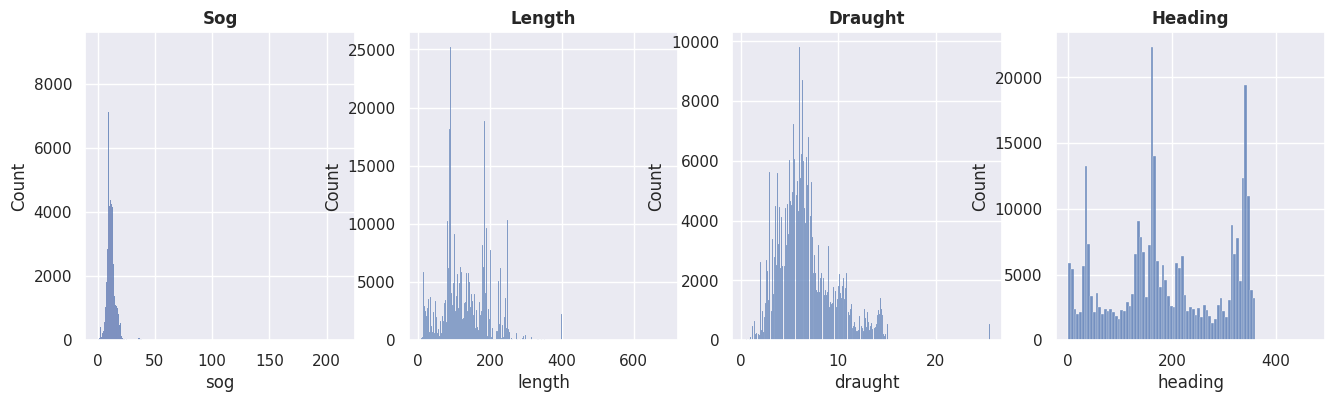

In [22]:
outlier_cols = ['sog', 'length', 'draught','heading']

fig, axes = plt.subplots(1, 4, figsize=(16,4))

for i, col in enumerate(outlier_cols):
    ax1 = sns.histplot(df[col], ax=axes[i])
    ax1.set_title(col.capitalize(), weight='bold')

# Anomaly detection/Outlier Analysis and removal [i.e., distance-based/density-based or clustering-based


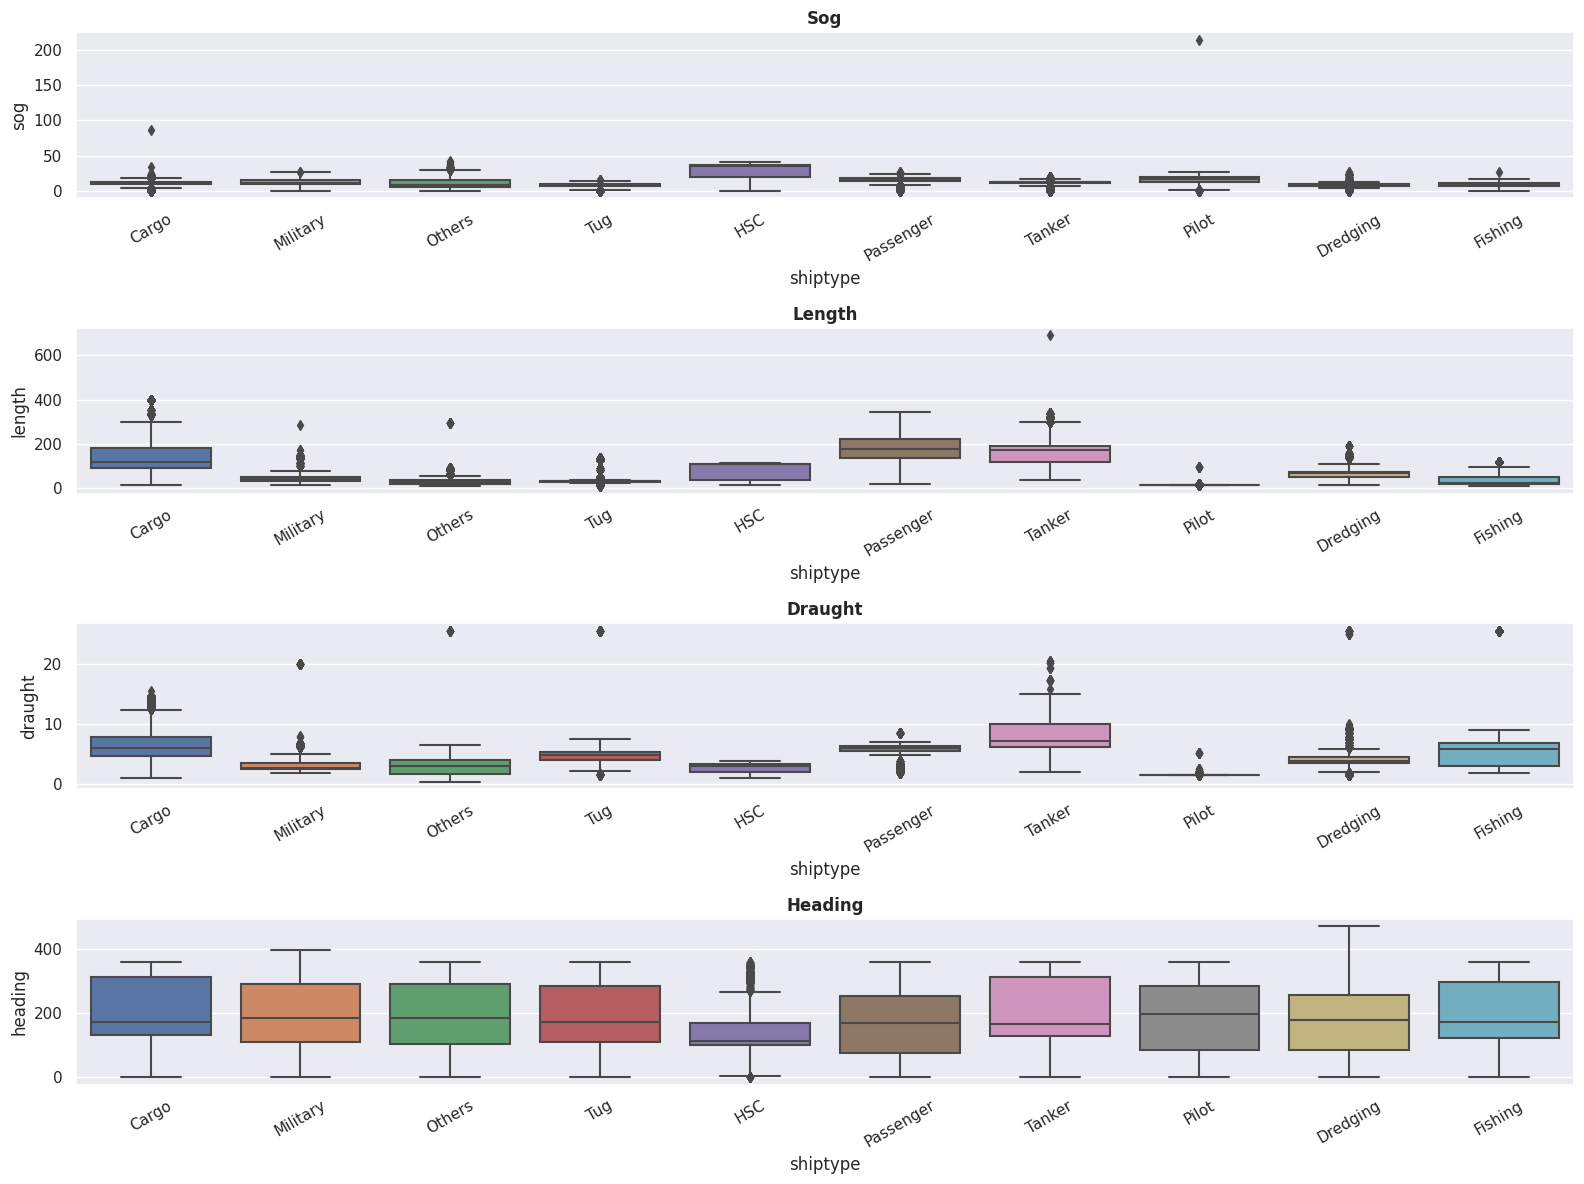

In [23]:
fig, axes = plt.subplots(4, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

In [24]:
# Potential rows to remove
df[(df.sog>200)|(df.length>500)]

,mmsi,sog,cog,heading,shiptype,width,length,draught
76551,211422510,13.9,134.5,133.0,Tanker,28.0,690.0,6.8
330195,219023648,214.0,343.7,356.0,Pilot,5.0,15.0,1.5


Above boxplots illustrates some major outliers in each of the 3 variables.

One of the (what appears to be) obvious errors would be the Pilot ship type having a speed over ground of over 200 knots. In addition to this, assuming the units are in metres, then the tanker length of 690 appears to be an error. Research suggests that the largest tanker made was ~458m.

The decision was made to drop values of length >500 and sog> 200.

It is also noted that, there are some key differences in the distribution of these variable values between the ship types suggesting that they will have a significant impact in the model performance.

In [25]:
df = df[(df.sog<=200)|(df.length<=500)]

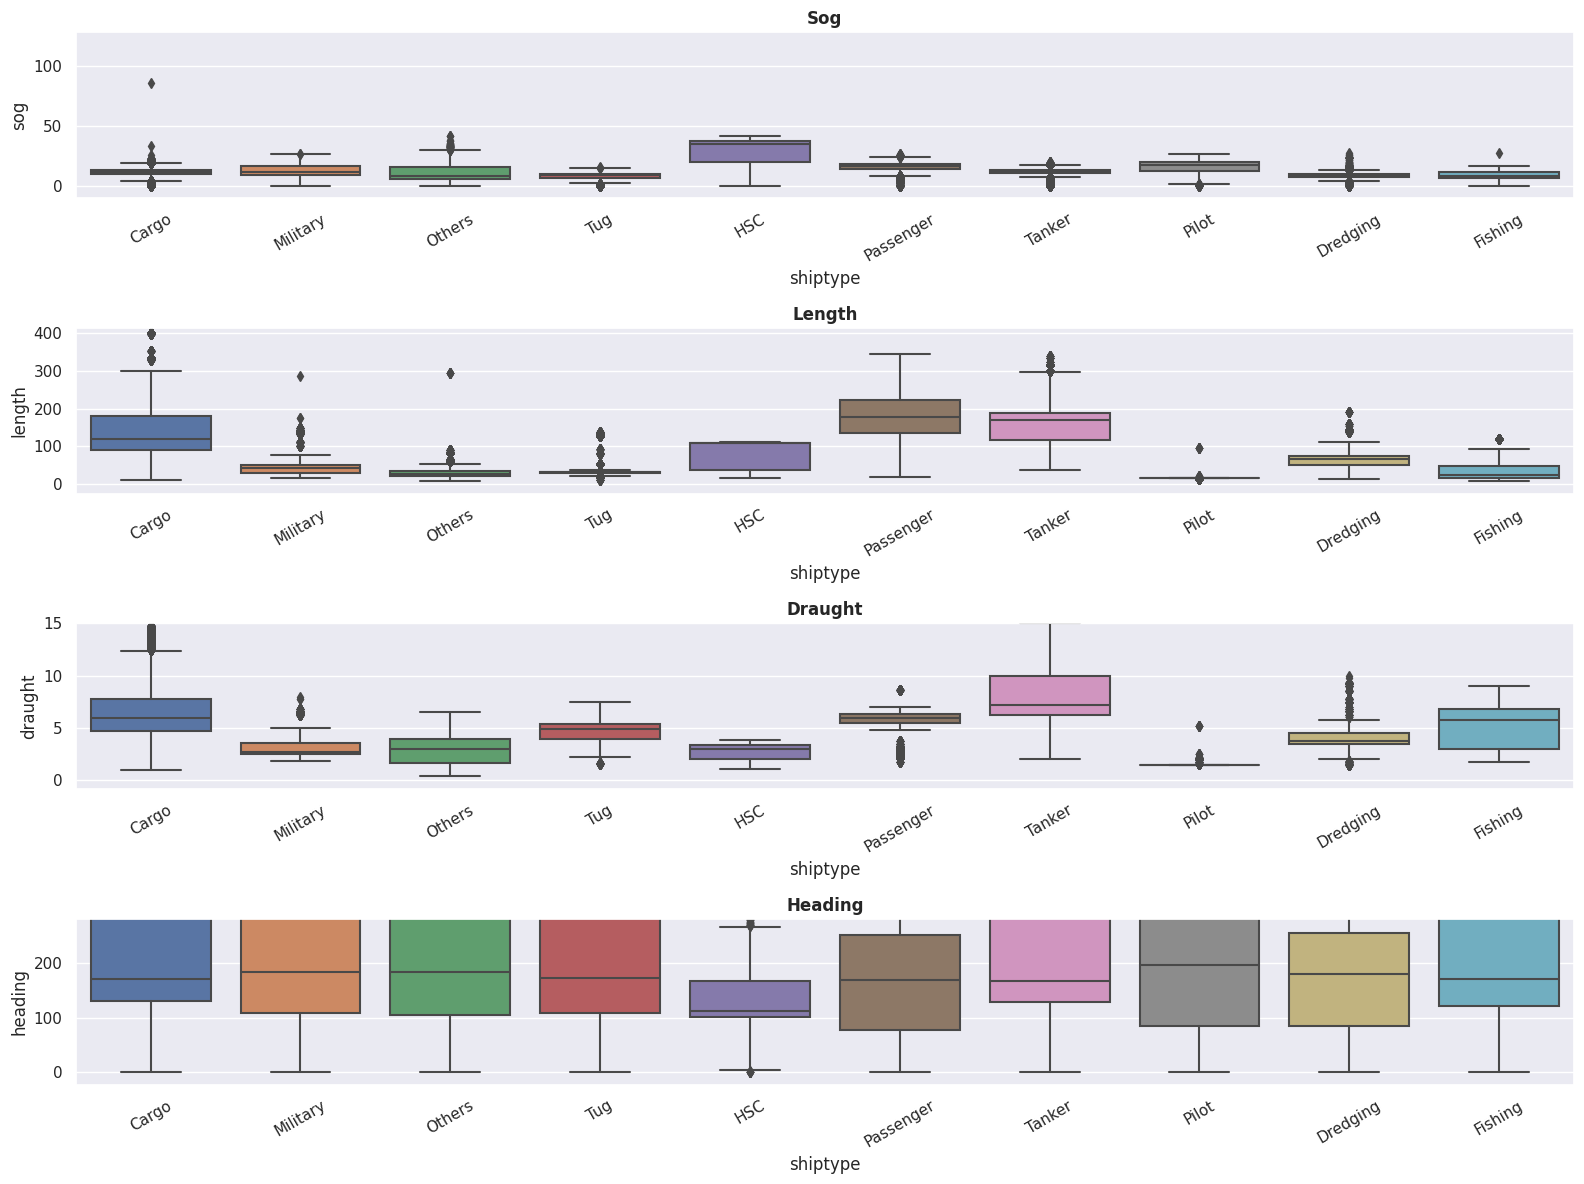

In [26]:
fig, axes = plt.subplots(4, 1, figsize=(16,12))


for i, col in enumerate(outlier_cols):
    ax = sns.boxplot(data=df, x='shiptype', y=col, ax=axes[i])
    ax.set_title(col.capitalize(), weight='bold')
    ax.set_ylim(top=int(df[col].max()*.6))
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
plt.tight_layout()

Now that the y axis has been adjusted we can clearly see the variation between ships for each of the variables. Observations are as follows:

Sog: Without suprise, the HSB has the highest values Length: We can see that length appears to be a clear idendentifier of shiptype, especially in the larger ones such as Cargo, Passenger, and Tanker. Draught: Again, some clear variations between shiptypes with Carco, Passenger, and Tankr having the higher values

In [27]:
df_apriori=df.copy()

In [28]:
df_apriori.head()

,mmsi,sog,cog,heading,shiptype,width,length,draught
4,212584000,0.0,153.0,106.0,Cargo,13.0,99.0,6.3
5,636020662,0.1,43.9,286.0,Cargo,23.0,149.0,6.3
7,246539000,0.0,3.8,293.0,Cargo,16.0,150.0,6.8
8,210307000,0.0,285.1,225.0,Cargo,16.0,90.0,5.2
11,219263000,0.0,353.9,100.0,Military,12.0,48.0,4.2


# Variable Transformation: Normalization, standardization, differencing

In [29]:
from sklearn.preprocessing import StandardScaler

# Select numerical variables for standardization
numerical_vars = ['sog', 'heading', 'width', 'length', 'draught','mmsi']

# Standardize the numerical variables
scaler = StandardScaler()
df[numerical_vars] = scaler.fit_transform(df[numerical_vars].fillna(0))
print(df.head())

        mmsi       sog    cog   heading  shiptype     width    length  \
4  -0.713642 -2.930007  153.0 -0.788562     Cargo -0.783828 -0.512758   
5   2.715035 -2.905057   43.9  0.891181     Cargo  0.184787  0.237729   
7  -0.438699 -2.930007    3.8  0.956505     Cargo -0.493243  0.252738   
8  -0.732079 -2.930007  285.1  0.321935     Cargo -0.493243 -0.647845   
11 -0.659560 -2.930007  353.9 -0.844554  Military -0.880689 -1.278253   

     draught  
4  -0.102556  
5  -0.102556  
7   0.069114  
8  -0.480230  
11 -0.823570  


# Discretization & Binarization: One hot encoding

In [30]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(drop=None)
# Perform one-hot encoding on 'shiptype' column
encoded_features = one_hot_encoder.fit_transform(df[['shiptype']]).toarray()
if hasattr(one_hot_encoder, 'get_feature_names_out'):
    feature_labels = one_hot_encoder.get_feature_names_out(['shiptype'])
else:
    feature_labels = one_hot_encoder.get_feature_names(['shiptype'])
encoded_df = pd.DataFrame(encoded_features, columns=feature_labels)
ais_data_encoded = pd.concat([df, encoded_df], axis=1)
ais_data_encoded.drop('shiptype', axis=1, inplace=True)
print(ais_data_encoded.head())

        mmsi       sog    cog   heading     width    length   draught  \
4  -0.713642 -2.930007  153.0 -0.788562 -0.783828 -0.512758 -0.102556   
5   2.715035 -2.905057   43.9  0.891181  0.184787  0.237729 -0.102556   
7  -0.438699 -2.930007    3.8  0.956505 -0.493243  0.252738  0.069114   
8  -0.732079 -2.930007  285.1  0.321935 -0.493243 -0.647845 -0.480230   
11 -0.659560 -2.930007  353.9 -0.844554 -0.880689 -1.278253 -0.823570   

    shiptype_Cargo  shiptype_Dredging  shiptype_Fishing  shiptype_HSC  \
4              0.0                0.0               0.0           0.0   
5              1.0                0.0               0.0           0.0   
7              0.0                0.0               0.0           0.0   
8              1.0                0.0               0.0           0.0   
11             0.0                0.0               0.0           0.0   

    shiptype_Military  shiptype_Others  shiptype_Passenger  shiptype_Pilot  \
4                 1.0              0.0      

In [31]:
ais_data_encoded.shape

(354659, 17)

In [32]:
df.shape

(324561, 8)

In [33]:
print(ais_data_encoded.isna().sum())

mmsi                  30098
sog                   30098
cog                   30098
heading               30098
width                 30098
length                30098
draught               30098
shiptype_Cargo        30098
shiptype_Dredging     30098
shiptype_Fishing      30098
shiptype_HSC          30098
shiptype_Military     30098
shiptype_Others       30098
shiptype_Passenger    30098
shiptype_Pilot        30098
shiptype_Tanker       30098
shiptype_Tug          30098
dtype: int64


In [34]:
ais_data_encoded = ais_data_encoded.dropna()

In [35]:
print(ais_data_encoded.isna().sum())

mmsi                  0
sog                   0
cog                   0
heading               0
width                 0
length                0
draught               0
shiptype_Cargo        0
shiptype_Dredging     0
shiptype_Fishing      0
shiptype_HSC          0
shiptype_Military     0
shiptype_Others       0
shiptype_Passenger    0
shiptype_Pilot        0
shiptype_Tanker       0
shiptype_Tug          0
dtype: int64


In [36]:
ais_data_encoded_RF=ais_data_encoded.copy()

In [37]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Subset the data
selected_rows = ais_data_encoded_RF.iloc[:50000, :]
X_rf = selected_rows.drop(columns=['cog']).values
y_rf = np.log1p(selected_rows['cog'].values)


In [38]:
print(np.isnan(y_rf).any())


False


In [39]:
# Find indices of rows with NaN values in y_train_rf
nan_indices = np.argwhere(np.isnan(y_rf))

# Remove rows with NaN values from both X_train_rf and y_train_rf
X_rf = np.delete(X_rf, nan_indices, axis=0)
y_rf = np.delete(y_rf, nan_indices)


In [40]:
print(np.isnan(y_rf).any())

False


In [41]:
# Get the original feature names
feature_names = selected_rows.drop(columns=['cog']).columns.tolist()

# Split the data into training and testing sets
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(
    X_rf, y_rf, test_size=0.2, random_state=5805, shuffle=True
)

# Perform Random Forest Regression
rfc = RandomForestRegressor(n_estimators=100, random_state=5805, n_jobs=-1)
rfc.fit(X_train_rf, y_train_rf)


RandomForestRegressor(n_jobs=-1, random_state=5805)

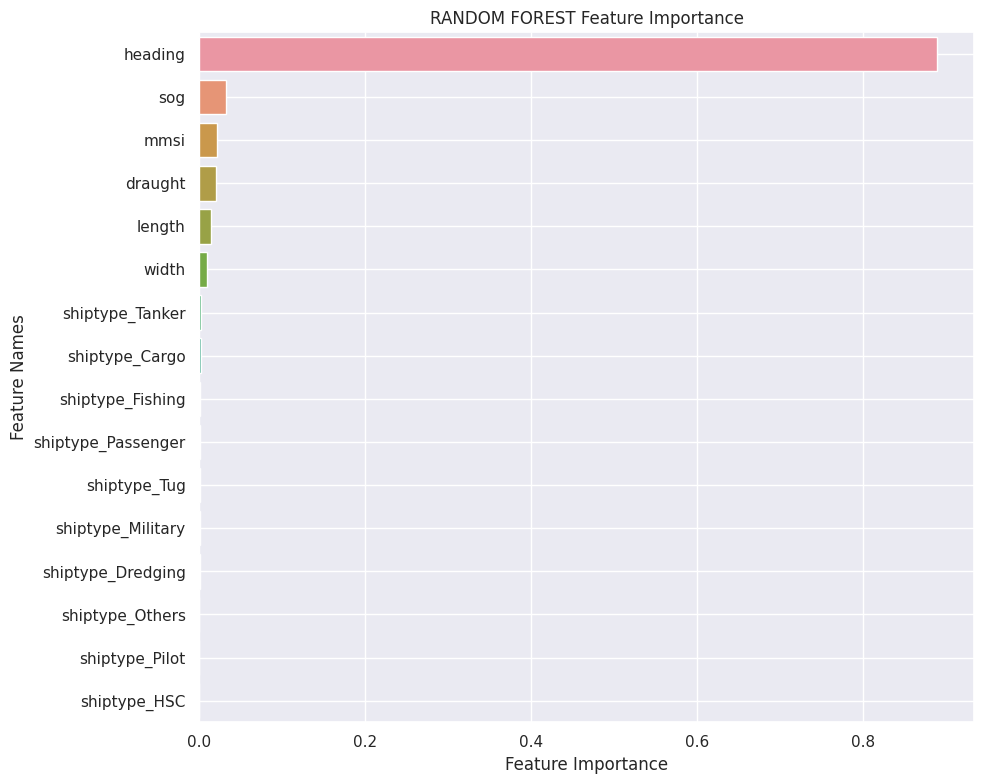

Removed Features: ['width', 'shiptype_Tanker', 'shiptype_Cargo', 'shiptype_Fishing', 'shiptype_Passenger', 'shiptype_Tug', 'shiptype_Military', 'shiptype_Dredging', 'shiptype_Others', 'shiptype_Pilot', 'shiptype_HSC']
Selected Features: ['heading', 'sog', 'mmsi', 'draught', 'length']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.696
Model:                            OLS   Adj. R-squared:                  0.696
Method:                 Least Squares   F-statistic:                 1.834e+04
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        01:42:24   Log-Likelihood:                -30537.
No. Observations:               40000   AIC:                         6.109e+04
Df Residuals:                   39994   BIC:                         6.114e+04
Df Model:                           5                                         
Cova

In [42]:
# Plot feature importance
def plot_feature_importance(importance, names, model_type, threshold=0.01):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data = {"feature_names": feature_names, "feature_importance": feature_importance}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=["feature_importance"], ascending=False, inplace=True)

    plt.figure(figsize=(10, 8))
    sns.barplot(x=fi_df["feature_importance"], y=fi_df["feature_names"])
    plt.title(f"{model_type} Feature Importance")
    plt.xlabel("Feature Importance")
    plt.ylabel("Feature Names")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    removed_features = fi_df[fi_df["feature_importance"] < threshold]["feature_names"]
    print("Removed Features:", removed_features.tolist())

    selected_features = fi_df[fi_df["feature_importance"] >= threshold]["feature_names"]
    print("Selected Features:", selected_features.tolist())

    return removed_features, selected_features

# Plot and select features
removed, selected = plot_feature_importance(rfc.feature_importances_, feature_names, "RANDOM FOREST")

# print("Removed Features:", removed.tolist())
# print("Selected Features:", selected.tolist())

# Drop insignificant features
X_train_rf_df = pd.DataFrame(X_train_rf, columns=feature_names)
X_test_rf_df = pd.DataFrame(X_test_rf, columns=feature_names)

# Drop insignificant features based on the feature selection from the Random Forest
X_train_rf_df.drop(removed, axis=1, inplace=True)
X_test_rf_df.drop(removed, axis=1, inplace=True)

# Perform regression OLS
lin_reg_rf = sm.OLS(y_train_rf, sm.add_constant(X_train_rf_df)).fit()
print(lin_reg_rf.summary())
y_pred_rf = lin_reg_rf.predict(sm.add_constant(X_test_rf_df))

# Do reverse transformation based on formula
y_test_hat_rf = np.expm1(y_pred_rf)

def mse_rf(y_true, y_pred):
    return round(np.mean((y_true - y_pred) ** 2), 3)
print("MSE:", mse_rf(np.expm1(y_test_rf), y_test_hat_rf))

# Creating a DataFrame for model statistics
table_2 = pd.DataFrame(columns=["AIC", "BIC", "Adj. R2", "MSE"])
table_2.loc["Random Forest Regression", "AIC"] = lin_reg_rf.aic.round(3)
table_2.loc["Random Forest Regression", "BIC"] = lin_reg_rf.bic.round(3)
table_2.loc["Random Forest Regression", "Adj. R2"] = lin_reg_rf.rsquared_adj.round(3)
table_2.loc["Random Forest Regression", "MSE"] = mse_rf(np.expm1(y_test_rf), y_test_hat_rf)
print(table_2)

In [43]:
ais_data_encoded.head()

,mmsi,sog,cog,heading,width,length,draught,shiptype_Cargo,shiptype_Dredging,shiptype_Fishing,shiptype_HSC,shiptype_Military,shiptype_Others,shiptype_Passenger,shiptype_Pilot,shiptype_Tanker,shiptype_Tug
4,-0.713642,-2.930007,153.0,-0.788562,-0.783828,-0.512758,-0.102556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2.715035,-2.905057,43.9,0.891181,0.184787,0.237729,-0.102556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.438699,-2.930007,3.8,0.956505,-0.493243,0.252738,0.069114,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,-0.732079,-2.930007,285.1,0.321935,-0.493243,-0.647845,-0.480230,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,-0.659560,-2.930007,353.9,-0.844554,-0.880689,-1.278253,-0.823570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [44]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

ais_data_encoded_RF = ais_data_encoded_RF.drop(removed, axis=1)
X = ais_data_encoded_RF.drop(columns=['cog']).values  # Drop the 'totalRent' column for features
y = ais_data_encoded_RF['cog'].values  # Select only the 'totalRent' column as the target variable

vif_data1 = pd.DataFrame()
vif_data1['feature'] = ais_data_encoded_RF.drop(columns=['cog']).columns
vif_data1['VIF'] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]

print("VIF Results (Before Dropping a Feature):")
print(vif_data1)

# Set the threshold for VIF
vif_threshold = 3

# Identify features with high VIF
high_vif_features = vif_data1[vif_data1['VIF'] > vif_threshold]['feature'].tolist()

print("Features with High VIF:", high_vif_features)

# Dropping features with high VIF from the DataFrame 'housing'
ais_data_encoded_RF = ais_data_encoded_RF.drop(columns=high_vif_features)
print("\nDataFrame After Removing Features with High VIF:")
print(ais_data_encoded_RF)

VIF Results (Before Dropping a Feature):
   feature       VIF
0     mmsi  1.298379
1      sog  1.159099
2  heading  1.004437
3   length  2.599081
4  draught  2.256437
Features with High VIF: []

DataFrame After Removing Features with High VIF:
            mmsi       sog    cog   heading    length   draught
4      -0.713642 -2.930007  153.0 -0.788562 -0.512758 -0.102556
5       2.715035 -2.905057   43.9  0.891181  0.237729 -0.102556
7      -0.438699 -2.930007    3.8  0.956505  0.252738  0.069114
8      -0.732079 -2.930007  285.1  0.321935 -0.647845 -0.480230
11     -0.659560 -2.930007  353.9 -0.844554 -1.278253 -0.823570
...          ...       ...    ...       ...       ...       ...
324556 -0.661677 -1.383074  314.4  1.115147 -1.773574 -1.475916
324557 -0.277588  0.363463  344.0  1.413768 -0.497748 -0.377228
324558 -0.714298 -0.509806  140.0 -0.499273 -0.677865 -0.960906
324559  2.715019 -0.160498  210.3  0.181956  1.753711  0.824462
324560  2.715019 -0.160498  210.4  0.181956  1.75371

In [45]:
ais_data_encoded_RF.head()

,mmsi,sog,cog,heading,length,draught
4,-0.713642,-2.930007,153.0,-0.788562,-0.512758,-0.102556
5,2.715035,-2.905057,43.9,0.891181,0.237729,-0.102556
7,-0.438699,-2.930007,3.8,0.956505,0.252738,0.069114
8,-0.732079,-2.930007,285.1,0.321935,-0.647845,-0.480230
11,-0.659560,-2.930007,353.9,-0.844554,-1.278253,-0.823570


In [46]:
ais_data_encoded.head()

,mmsi,sog,cog,heading,width,length,draught,shiptype_Cargo,shiptype_Dredging,shiptype_Fishing,shiptype_HSC,shiptype_Military,shiptype_Others,shiptype_Passenger,shiptype_Pilot,shiptype_Tanker,shiptype_Tug
4,-0.713642,-2.930007,153.0,-0.788562,-0.783828,-0.512758,-0.102556,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,2.715035,-2.905057,43.9,0.891181,0.184787,0.237729,-0.102556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,-0.438699,-2.930007,3.8,0.956505,-0.493243,0.252738,0.069114,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
8,-0.732079,-2.930007,285.1,0.321935,-0.493243,-0.647845,-0.480230,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,-0.659560,-2.930007,353.9,-0.844554,-0.880689,-1.278253,-0.823570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
X = ais_data_encoded.drop(columns=['sog']).values

Number of features needed to explain more than 90% of the dependent variance: 1


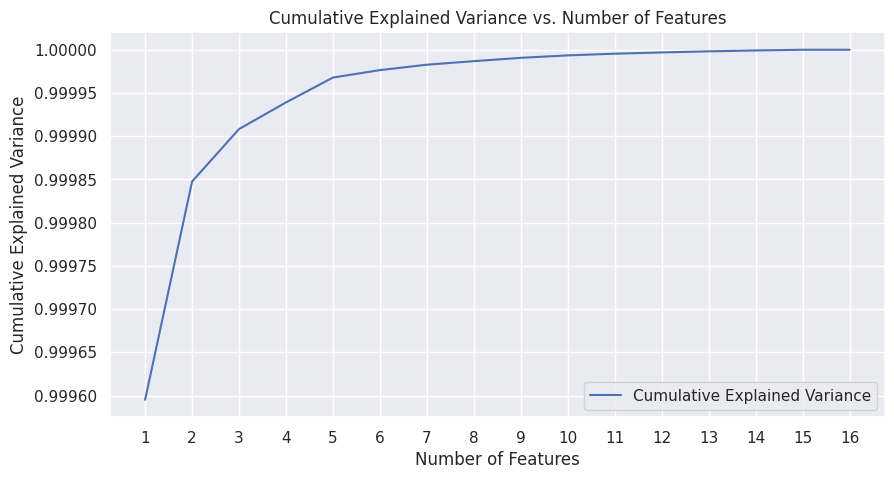

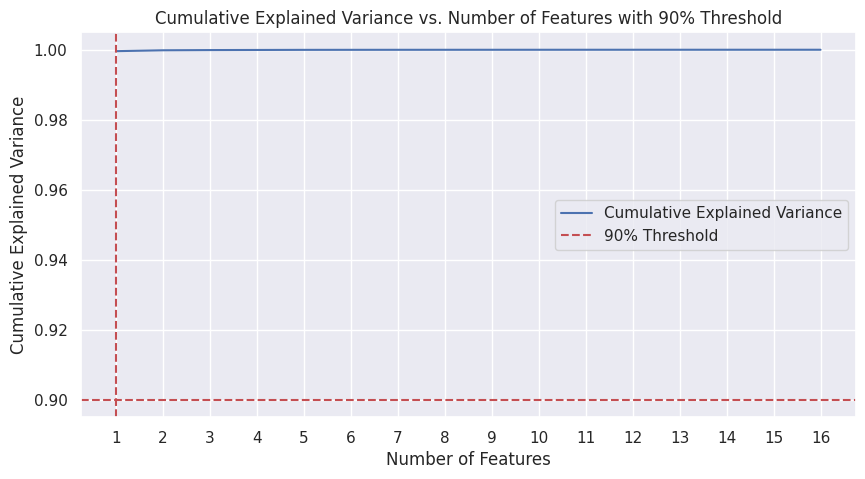

In [48]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

pca = PCA()
X_pca = pca.fit_transform(X)
explained_var_ratio = pca.explained_variance_ratio_
cumulative_var_ratio = np.cumsum(explained_var_ratio)
num_features_90_percent = np.where(cumulative_var_ratio > 0.90)[0][0] + 1
print("Number of features needed to explain more than 90% of the dependent variance:", num_features_90_percent)

# Plotting the cumulative explained variance versus the number of features.
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(cumulative_var_ratio) + 1, 1), cumulative_var_ratio, label="Cumulative Explained Variance")
plt.xticks(np.arange(1, len(cumulative_var_ratio) + 1, 1))
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.title("Cumulative Explained Variance vs. Number of Features")
plt.show()

# Drawing a vertical line and horizontal line showing the exact 90% threshold and the corresponding number of features.
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(cumulative_var_ratio) + 1, 1), cumulative_var_ratio, label="Cumulative Explained Variance")
plt.axvline(x=num_features_90_percent, color="r", linestyle="--", label="90% Threshold")
plt.axhline(y=0.9, color="r", linestyle="--")
plt.xticks(np.arange(1, len(cumulative_var_ratio) + 1, 1))
plt.xlabel("Number of Features")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.legend()
plt.title("Cumulative Explained Variance vs. Number of Features with 90% Threshold")
plt.show()

        mmsi       sog   heading     width    length   draught  shiptype_Cargo  shiptype_Dredging  shiptype_Fishing  shiptype_HSC  shiptype_Military  shiptype_Others  shiptype_Passenger  shiptype_Pilot  shiptype_Tanker  shiptype_Tug
4  -0.713642 -2.930007 -0.788562 -0.783828 -0.512758 -0.102556             0.0                0.0               0.0           0.0                1.0              0.0                 0.0             0.0              0.0           0.0
5   2.715035 -2.905057  0.891181  0.184787  0.237729 -0.102556             1.0                0.0               0.0           0.0                0.0              0.0                 0.0             0.0              0.0           0.0
7  -0.438699 -2.930007  0.956505 -0.493243  0.252738  0.069114             0.0                0.0               0.0           0.0                1.0              0.0                 0.0             0.0              0.0           0.0
8  -0.732079 -2.930007  0.321935 -0.493243 -0.647845 -0.480230      

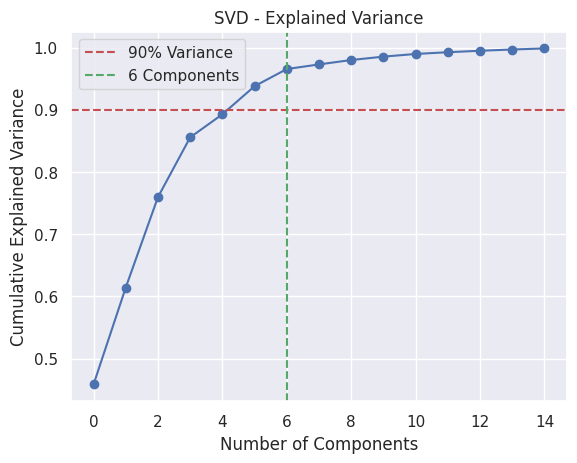

In [49]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

numerical_data = ais_data_encoded.select_dtypes(include=[np.number])
numerical_data.drop('cog', axis=1, inplace=True)
print(numerical_data.head().to_string())

# Performing Singular Value Decomposition
svd = TruncatedSVD(n_components=min(numerical_data.shape[0], numerical_data.shape[1]) - 1)
svd_result = svd.fit_transform(numerical_data)
explained_variance_ratio = svd.explained_variance_ratio_
print(explained_variance_ratio)
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Plotting the explained variance
plt.plot(cumulative_explained_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('SVD - Explained Variance')

threshold = 0.90
plt.axhline(y=threshold, color='r', linestyle='--', label=f'{threshold*100:.0f}% Variance')
num_components_threshold = np.argmax(cumulative_explained_variance >= threshold) + 1

plt.axvline(x=num_components_threshold, color='g', linestyle='--', label=f'{num_components_threshold} Components')

plt.legend()
plt.show()

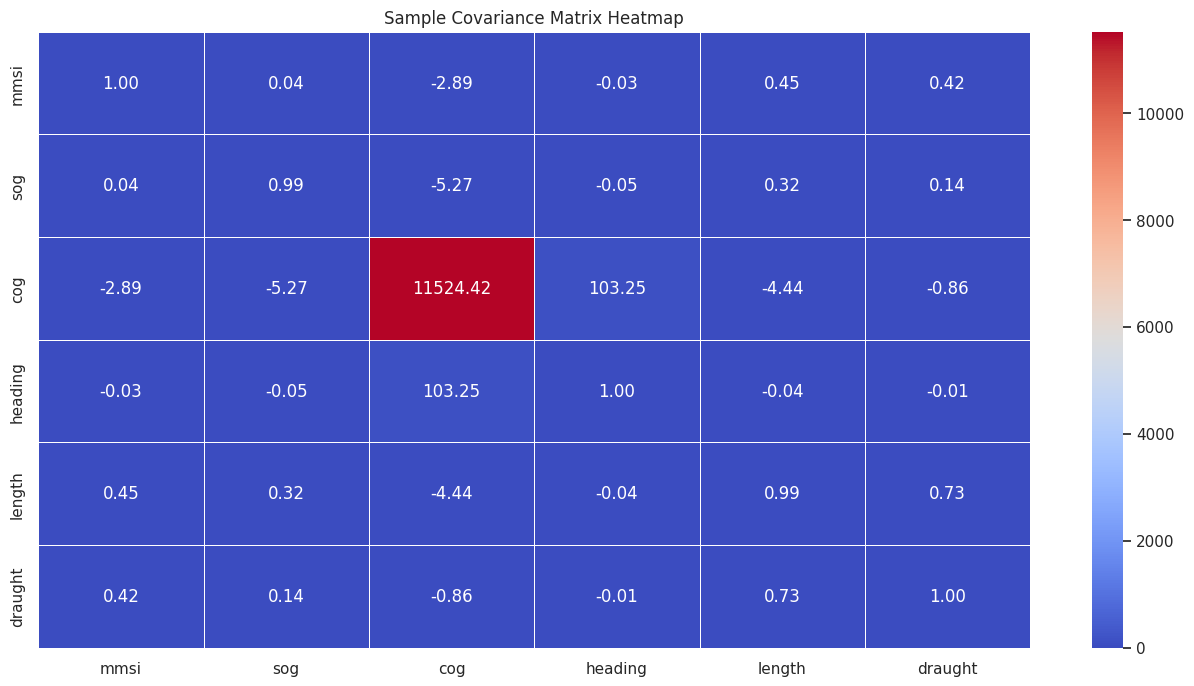

In [50]:
cov_matrix = ais_data_encoded_RF.cov()

# Plotting the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Sample Covariance Matrix Heatmap')
plt.show()

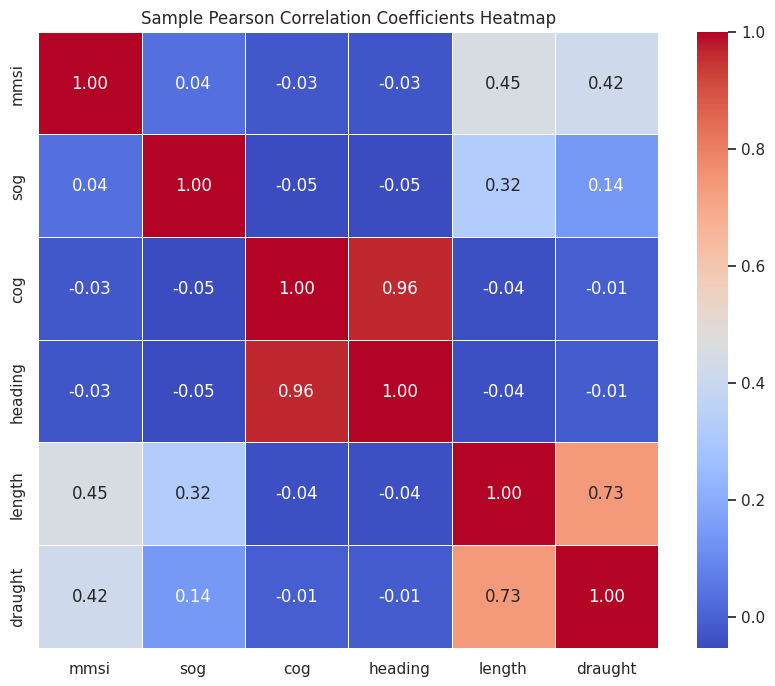

In [51]:
corr_matrix = ais_data_encoded_RF.corr()

# Plotting the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Sample Pearson Correlation Coefficients Heatmap')
plt.show()

## **Phase-2**

In [52]:
print(ais_data_encoded_RF.isnull().sum())


mmsi       0
sog        0
cog        0
heading    0
length     0
draught    0
dtype: int64


In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split

X = ais_data_encoded_RF.drop('cog', axis=1)
y = ais_data_encoded_RF['cog']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

Training set shape: (235570, 5)
Test set shape: (58893, 5)


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import numpy as np


lr = LinearRegression()
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
print('Training R-squared:', train_r2)
print('Training MSE:', train_mse)

test_r2 = r2_score(y_test, y_test_pred)
print('Test R-squared:', test_r2)

X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

model_sm = sm.OLS(y_train, X_train_sm).fit()
model_stats = model_sm.summary()
print(model_stats)


Training R-squared: 0.9276439705797568
Training MSE: 834.5923505019917
Test R-squared: 0.9278071831293299
                            OLS Regression Results                            
Dep. Variable:                    cog   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 6.040e+05
Date:                Fri, 28 Nov 2025   Prob (F-statistic):               0.00
Time:                        01:42:29   Log-Likelihood:            -1.1266e+06
No. Observations:              235570   AIC:                         2.253e+06
Df Residuals:                  235564   BIC:                         2.253e+06
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

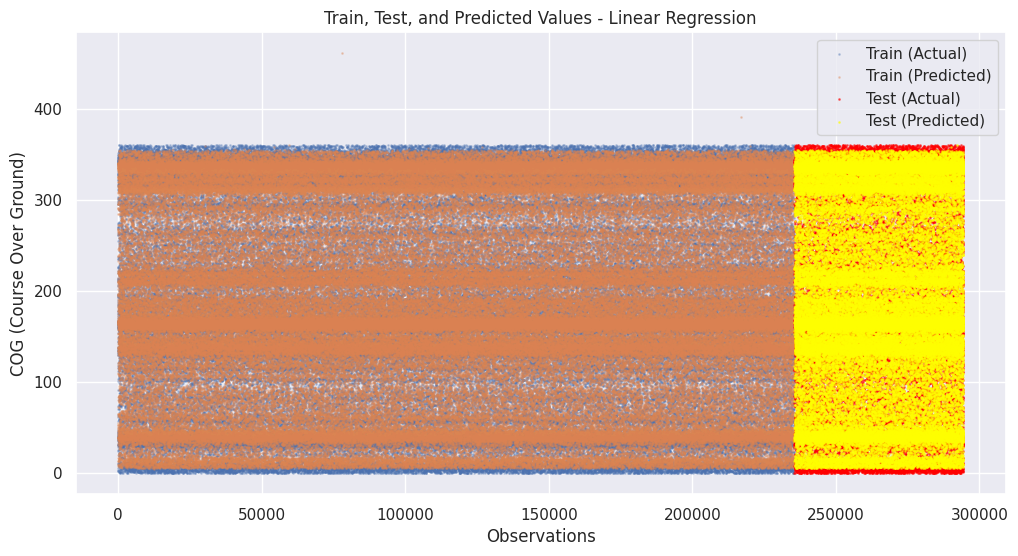


Model Performance:
Training R²: 0.9276
Test R²: 0.9278
Training MSE: 834.5924


In [55]:

import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot training predictions
plt.scatter(range(len(y_train)), y_train, label='Train (Actual)', alpha=0.3, s=1)
plt.scatter(range(len(y_train)), y_train_pred, label='Train (Predicted)', alpha=0.3, s=1)

# Plot test actual and predicted
offset = len(y_train)
plt.scatter(range(offset, offset + len(y_test)), y_test, label='Test (Actual)', color='red', alpha=0.5, s=1)
plt.scatter(range(offset, offset + len(y_test)), y_test_pred, label='Test (Predicted)', color='yellow', alpha=0.5, s=1)

plt.legend()
plt.xlabel('Observations')
plt.ylabel('COG (Course Over Ground)')
plt.title('Train, Test, and Predicted Values - Linear Regression')
plt.show()

print(f"\nModel Performance:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MSE: {train_mse:.4f}")

In [56]:
f_statistic = model_sm.fvalue
f_p_value = model_sm.f_pvalue

print('F-statistic:', f_statistic)
print('F-test p-value:', f_p_value)

t_test_p_values = model_sm.pvalues
print('T-test p-values:\n', t_test_p_values)

F-statistic: 604011.9283397666
F-test p-value: 0.0
T-test p-values:
 const      0.000000e+00
mmsi       9.740963e-01
sog        6.585434e-07
heading    0.000000e+00
length     1.731960e-13
draught    6.587281e-25
dtype: float64


In [57]:
confidence_intervals = model_sm.conf_int()
print('Confidence intervals for the model coefficients:\n', confidence_intervals)

Confidence intervals for the model coefficients:
                   0           1
const    190.267459  190.500791
mmsi      -0.130539    0.134938
sog        0.193385    0.444951
heading  103.423224  103.657310
length    -0.898671   -0.521035
draught    0.747557    1.098600


These intervals provide a range of values within which we can be confident that the true value of the coefficient lies, with a certain level of confidence (typically 95%).

In [58]:

from sklearn.linear_model import LinearRegression
X = ais_data_encoded.drop(columns=['cog','mmsi']).values  # Drop the 'cog','mmsi'  column for features
y = ais_data_encoded['cog'].values  

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)
lr = LinearRegression()
lr.fit(x_train, y_train)
y_predict = lr.predict(x_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_predict)


0.9263377181630464

----------------------------------------
----------------------------------------